## Generate IDPP path and modify 

In [1]:
from pymatgen_diffusion.neb.pathfinder import IDPPSolver
from pymatgen.core import Structure
import numpy as np
import os

In [5]:
# run IDPP
source = "Ag_2"
dirname = "C:\\ComputMatSci\\IDPP_test\\%s\\" % source
init_struct = Structure.from_file(os.path.join(dirname, "POSCAR_ini"), False)
final_struct = Structure.from_file(os.path.join(dirname, "POSCAR_fin"), False)
obj = IDPPSolver.from_endpoints(endpoints=[init_struct, final_struct], nimages=10, sort_tol=0)
idpp_path = obj.run(maxiter=5000, tol=1e-5, gtol=1e-3)

In [6]:
# remove clash
clash_removed_path, attr_force_log, attr_index_log, rpl_force_log, rpl_index_log, disp_log = obj.clash_removal(idpp_path, steric_threshold=2.88, max_bond_length=2.88, max_iter=200, k_bonded=0.1, step_size=0.005)

c:\ComputMatSci\IDPP_test\pymatgen\pymatgen-diffusion\pymatgen_diffusion\neb\pathfinder.py:522: UserWarning: Maximum iteration number is reached without convergence!
  UserWarning)


In [17]:
# rerun
obj_rerun = IDPPSolver(clash_removed_path)
rerun_path = obj_rerun.rerun(maxiter = 5000, tol=1e-5, gtol=1e-3)

## Saving data

In [7]:
# create saving folder
from datetime import datetime
now = datetime.now()
today = now.strftime("%Y%m%d")
path = os.path.join("C:\\ComputMatSci\\IDPP_test\\pymatgen\\%s\\" %source, today)
if not os.path.exists(path):
    os.mkdir(path)
i = 1
saveDir = os.path.join(path,"%s_test_%02d"%(today,i))
while(os.path.exists(saveDir)): 
    i += 1
    saveDir = os.path.join(path,"%s_test_%02d"%(today,i))
os.mkdir(saveDir)


In [8]:
# save structures as POSCAR
result = clash_removed_path
for n,struct in enumerate(result):
    os.mkdir("%s\\%02d" % (saveDir,n))
    struct.to(fmt="poscar",filename="%s\\%02d\\POSCAR" % (saveDir,n))

In [9]:
# save f_log and disp_log
np.savetxt(os.path.join(saveDir, "attr_force_log.txt"), attr_force_log)
np.savetxt(os.path.join(saveDir, "rpl_force_log.txt"), rpl_force_log)
np.savetxt(os.path.join(saveDir, "attr_index_log.txt"), attr_index_log)
np.savetxt(os.path.join(saveDir, "rpl_index_log.txt"), rpl_index_log)
np.savetxt(os.path.join(saveDir, "disp_log.txt"), disp_log)

In [ ]:
# output log
with open(os.path.join(saveDir, "log.txt"),"a" ) as f:
    log = "r = %d \nmax_bond_length = %f\nradius = %f\nmax_iteration = %d\ntolerance = %d\ngtolerance%d" % (5, 4.09, 1.44, 5000, 1e-5, 1e-3)
    f.write(log)
    f.close()
# save probes
with open(os.path.join(saveDir, "d_3-4.txt"),"w") as f:
    for i in probe1:
        f.write("%f\n" % i)
with open(os.path.join(saveDir, "d_3-9.txt"),"w") as f:
    for i in probe2:
        f.write("%f\n" % i)
with open(os.path.join(saveDir, "d_3-10.txt"),"w") as f:
    for i in probe3:
        f.write("%f\n" % i)

np.savetxt(os.path.join(saveDir, "d_26.txt"),d_26)

with open(os.path.join(saveDir, "neighbor_26.txt"),"w") as f:
    for i in range(len(n_26)):
        f.write("iteration %d \n" % i)
        for ni in n_26[i]:
            f.write(str(ni)+"\n")

## Plot

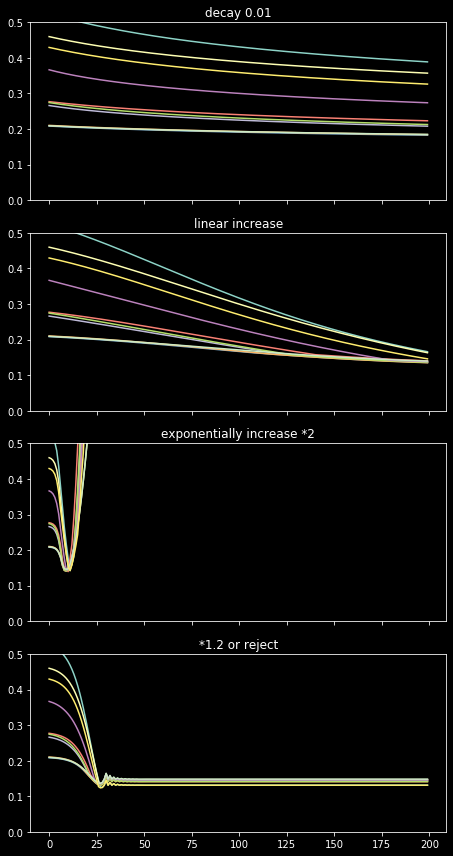

In [42]:
import matplotlib.pyplot as plt

attr_force_03 = np.loadtxt("C:\\ComputMatSci\\IDPP_test\\pymatgen\\Ag_2\\20191028\\20191028_test_03\\attr_force_log.txt")
attr_force_04 = np.loadtxt("C:\\ComputMatSci\\IDPP_test\\pymatgen\\Ag_2\\20191028\\20191028_test_04\\attr_force_log.txt")
attr_force_05 = np.loadtxt("C:\\ComputMatSci\\IDPP_test\\pymatgen\\Ag_2\\20191028\\20191028_test_05\\attr_force_log.txt")
attr_force_06 = np.loadtxt("C:\\ComputMatSci\\IDPP_test\\pymatgen\\Ag_2\\20191028\\20191028_test_06\\attr_force_log.txt")

x = np.arange(200)
y_lb = 0
y_ub = 0.5
plt.figure(figsize=[6.4, 12])
ax1 = plt.subplot(411)
plt.plot(x, attr_force_03)
ax1.set_title("decay 0.01")
ax1.set_ylim(y_lb, y_ub)
plt.setp(ax1.get_xticklabels(),visible=False)

ax2 = plt.subplot(412)
plt.plot(attr_force_04)
ax2.set_title("linear increase")
ax2.set_ylim(y_lb, y_ub)
plt.setp(ax2.get_xticklabels(),visible=False)

ax3 = plt.subplot(413)
plt.plot(attr_force_05)
ax3.set_title("exponentially increase *2")
ax3.set_ylim(y_lb, y_ub)
plt.setp(ax3.get_xticklabels(),visible=False)

ax4 = plt.subplot(414)
plt.plot(attr_force_06)
ax4.set_title("*1.2 or reject")
ax4.set_ylim(y_lb, y_ub)

# plt.title("different step size dynamics (all initial step sizes are 0.005 ")
plt.tight_layout()
plt.show()

## Testing

In [4]:
# check d_26
count = 0
for i in d_26:
    for j in i:
        diff = abs(j - 2.88)
        if (diff < 0.01 ):
            count += 1
print(count)

In [6]:
import itertools
too_close = []
too_far = []
for ni in range(10):
    for i, j in itertools.combinations(range(26),2):
        d = target_dists[ni][i][j]
        if (d < 5 and d > 4.09 ):
            too_far.append("image: %d i: %d j: %d d_ij: %f" % (ni, i, j, d))
        if (d < 2.88 and d > 0):
            too_close.append("image: %d i: %d j: %d d_ij: %f" % (ni, i, j, d))

In [53]:
from operator import attrgetter, itemgetter
n = init_struct.get_all_neighbors(r=3)
n[0].sort(key=attrgetter('distance'))
n[0].attrgetter('distance')

In [4]:
for i in range(5):
    print("-----%d-----" %i)
    for j in range(5):
        if j > 4:
            break
        print(j)

-----0-----
0
1
2
3
4
-----1-----
0
1
2
3
4
-----2-----
0
1
2
3
4
-----3-----
0
1
2
3
4
-----4-----
0
1
2
3
4
